In [10]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

import random

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [12]:
def make_dataset_loaders(num_classes, batch_size, num_workers, image_size):
    root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
    dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=20, shuffle_images=False)

    class_images = {i: [] for i in range(num_classes)}

    # Group images by class
    for image_path, class_label in dataset:
        class_images[class_label].append((image_path, class_label))

    # Initialize training and test sets
    train_set = []
    test_set = []

    # Select 5 images for training and 15 for testing from each class
    for class_label, images in class_images.items():
        train_set.extend(random.sample(images, k=5))
        test_set.extend(list(set(images) - set(train_set)))


    train_transforms = transforms.Compose(
            [
                transforms.RandomCrop(80, padding=8),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=5),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    test_transforms = transforms.Compose(
            [   
                transforms.RandomCrop(80, padding=8),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        
    train_dataset = Dataset(dataset=train_set, path=root_dir, phase='train', transform=train_transforms)
    test_dataset = Dataset(dataset=test_set, path=root_dir, phase='test', transform=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # print_class_distribution(train_dataset, "Training", label_mapping)
    # print_class_distribution(test_dataset, "Testing", label_mapping)

    return train_loader, test_loader, label_mapping

In [13]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing -> batch: %d correct: %d num of images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, test_loader, num_epochs, learning_rate):

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(params= net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_test, test_loss = eval(net, test_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(test_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, test accuracy: %f test loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_test, test_loss))

        scheduler.step()

    return net, training_losses, val_losses

In [14]:
from models.resnet18 import ResNet18

batch_size = 3
num_workers = 4
learning_rate = 0.0001 # 0.00005 - the best one so far
num_epochs = 5
num_classes = 5
episodes = 5
image_size = 224

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}")
print(f"Number of Classes: {num_classes}")
print(f"Number of Episodes: {episodes}\n")

total_test_loss = 0.0
total_test_acc = 0.0

for episode in range(episodes):
    print('--------------------------------------------------------------')
    print(f"Training Episode: {episode}")

    loaded_model = torch.load(os.path.join(os.getcwd(), 'pretrained/resnet_model_best.pth'), map_location=device)
    model = ResNet18(num_classes=50).to(device)

    # Load the state dictionary into your model
    model.load_state_dict(loaded_model)
        
    in_features = model.resnet18.fc.in_features
    model.resnet18.fc = nn.Linear(in_features, num_classes).to(device)

    for param in model.parameters():
        param.requires_grad = True

    train_loader, test_loader, label_mapping = make_dataset_loaders(num_classes=num_classes, batch_size=batch_size, num_workers=num_workers, image_size=image_size)
    model, training_losses, val_losses = train(net=model, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, learning_rate=learning_rate)

    acc_test, test_loss = eval(model, test_loader)
    total_test_loss += test_loss
    total_test_acc += acc_test
    print('\naccuracy on testing data: %f' % acc_test)
    print('loss on testing data: %f' % test_loss)

print("---------------------------------------------")   
print(f"Average Test Accuracy: {total_test_acc/episodes}")
print(f"Average Test Loss: {total_test_loss/episodes}")

Hyperparameters:
Batch Size: 3
Learning Rate: 0.0001
Number of Epochs: 5
Number of Workers: 4
Number of Classes: 5
Number of Episodes: 5

--------------------------------------------------------------
Training Episode: 0
Using 20 images per class Highway
Using 20 images per class SeaLake
Using 20 images per class River
Using 20 images per class Industrial
Using 20 images per class HerbaceousVegetation
training -> epoch: 0, batch: 8, loss: 1.353338
testing -> batch: 24 correct: 31 num of images: 75
epoch: 0, lr: 0.000100, accuracy: 0.520000, avg. loss: 1.300940, test accuracy: 0.413333 test loss: 1.367808

training -> epoch: 1, batch: 8, loss: 1.922100
testing -> batch: 24 correct: 49 num of images: 75
epoch: 1, lr: 0.000100, accuracy: 0.440000, avg. loss: 1.159376, test accuracy: 0.653333 test loss: 0.928917

training -> epoch: 2, batch: 8, loss: 1.353479
testing -> batch: 24 correct: 53 num of images: 75
epoch: 2, lr: 0.000100, accuracy: 0.680000, avg. loss: 0.914660, test accuracy: 0

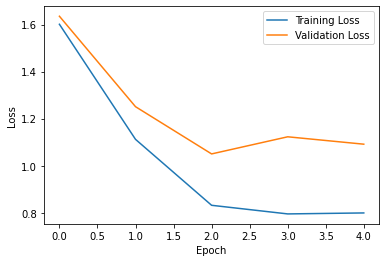

In [15]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.plot(val_losses, label='Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.eval()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
        
reverse_transform = transforms.Compose([
    transforms.CenterCrop(80),                
    transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
    transforms.ToPILImage(),
    transforms.Resize((image_size+8, image_size+8)),
])

all_images = []
all_predictions = []

# Perform inference and accumulate results
with torch.no_grad():
    for i_batch, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Convert images to PIL format and accumulate
        for i in range(images.size(0)):
            image = reverse_transform(images[i].cpu())
            all_images.append(image)
            all_predictions.append((label_mapping[labels[i].item()], label_mapping[predictions[i].item()]))


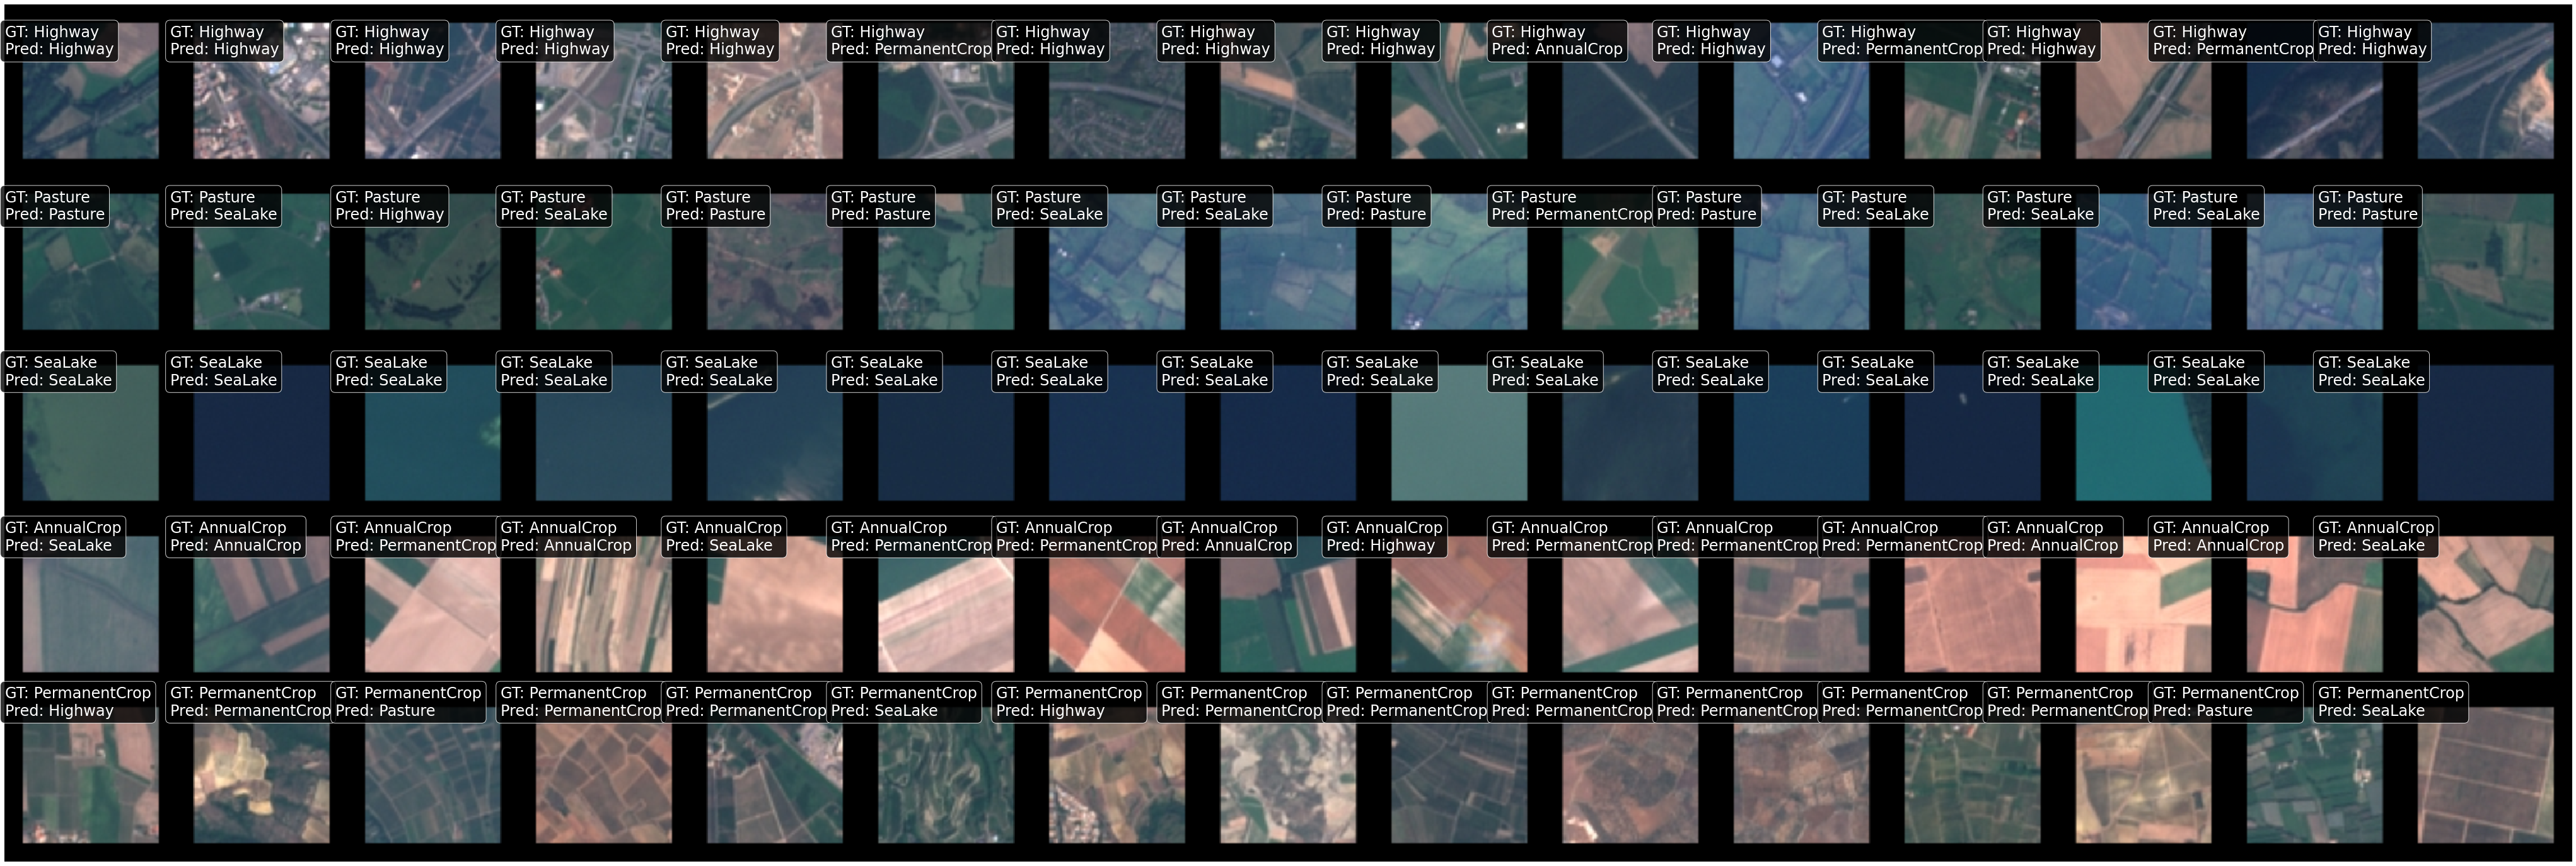

In [17]:
plt.figure(figsize=(75, 25))  # Adjust the figsize as needed
grid_images = make_grid([transforms.ToTensor()(img) for img in all_images], nrow=15)  # Adjust nrow as needed

# Use 'nearest' interpolation for better quality
plt.imshow(grid_images.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')

# Display the predictions as titles with a background
for i, (ground_truth, prediction) in enumerate(all_predictions):
    row = 0.3 + i // 15  # Calculate the row based on the index
    col = i % 15   # Calculate the column based on the index
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="black", alpha=0.8)
    plt.text(col * 226, row * 226, f'GT: {ground_truth}\nPred: {prediction}', color='white', fontsize=24, bbox=bbox_props)

plt.show()

In [18]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), f'trained/resnet18.pth'))